<a href="https://colab.research.google.com/github/soumya-mishra/Assembly-Fault-Detection/blob/master/Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


### Labels and Data

In [ ]:
labels = raw_data[:, -1] 
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

### MinMax scaling

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
set(train_labels)

{0.0, 1.0}

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate Normal Data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

#Separate Abnormal Data
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
anomalous_train_data

<tf.Tensor: shape=(1639, 140), dtype=float32, numpy=
array([[0.4304001 , 0.35345322, 0.30342638, ..., 0.30506894, 0.262255  ,
        0.2502011 ],
       [0.4494794 , 0.37906834, 0.3202905 , ..., 0.31546655, 0.39611116,
        0.46317974],
       [0.49198422, 0.4355403 , 0.3698029 , ..., 0.5260356 , 0.52524984,
        0.5278486 ],
       ...,
       [0.43457043, 0.362154  , 0.34958026, ..., 0.3179064 , 0.3426891 ,
        0.49215436],
       [0.4814947 , 0.4255184 , 0.38368973, ..., 0.29031053, 0.3311408 ,
        0.4467481 ],
       [0.4276824 , 0.3507402 , 0.31587753, ..., 0.3177887 , 0.33242297,
        0.419218  ]], dtype=float32)>

In [ ]:
normal_train_data[0]

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.57030463, 0.46561658, 0.29058117, 0.17791584, 0.09538919,
       0.08467858, 0.20195104, 0.3163002 , 0.33732033, 0.41424882,
       0.47070596, 0.4691905 , 0.47767755, 0.4800409 , 0.47027245,
       0.4729927 , 0.47917148, 0.48027468, 0.4692887 , 0.46106863,
       0.46148038, 0.4465829 , 0.45325327, 0.45610094, 0.4489618 ,
       0.4432532 , 0.43402174, 0.44307235, 0.43250525, 0.43014902,
       0.41454658, 0.4120653 , 0.4042028 , 0.41054544, 0.4082913 ,
       0.40342993, 0.39648476, 0.39332044, 0.39158815, 0.39603877,
       0.40746954, 0.4053118 , 0.4173488 , 0.41624558, 0.42334118,
       0.44590637, 0.4455184 , 0.44474098, 0.44404328, 0.45673218,
       0.45217463, 0.4532504 , 0.46082932, 0.46695936, 0.46631944,
       0.4743283 , 0.4629709 , 0.4738895 , 0.46788898, 0.4673448 ,
       0.48026675, 0.4843984 , 0.48574668, 0.48985568, 0.49317348,
       0.4883041 , 0.49913937, 0.5057092 , 0.5078241 , 0.51323026,
       0.52119

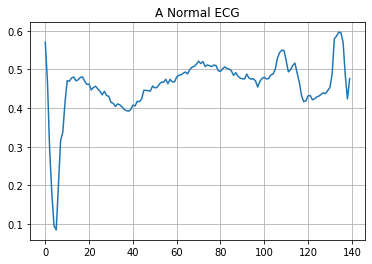

In [ ]:
#Plot Normal Data
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

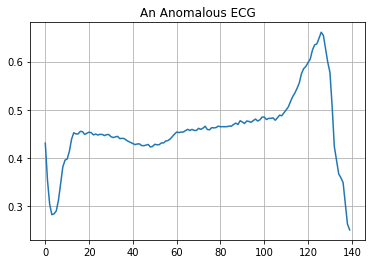

In [ ]:
#Plot Abnormal Data
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build Model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector,self).__init__()
    self.encoder = tf.keras.Sequential([layers.Dense(32,activation="relu"),
                                        layers.Dense(16,activation="relu"),
                                        layers.Dense(8,activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')


### autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0573 - val_loss: 0.0527
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0544 - val_loss: 0.0509
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0506 - val_loss: 0.0491
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0466 - val_loss: 0.0471
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0427 - val_loss: 0.0450
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0392 - val_loss: 0.0430
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0361 - val_loss: 0.0414
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0334 - val_loss: 0.0400
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0385
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0292 - val_loss: 0.0376
Epoch 11/20
5/5 [==============

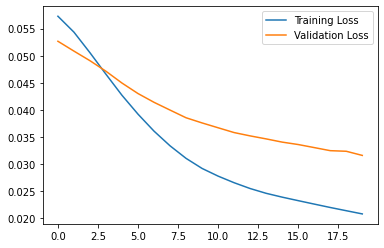

In [ ]:
# Plot Training Loss and Validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

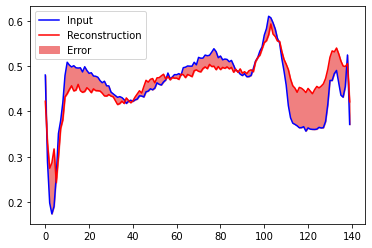

In [ ]:
#You will soon classify an ECG as anomalous if the reconstruction error is greater
#than one standard deviation from the normal training examples.
#First, let's plot a normal ECG from the training set, 
#the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Compare Normal Data and Decoded data in a plot.

In [ ]:
normal_test_data

<tf.Tensor: shape=(560, 140), dtype=float32, numpy=
array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
        0.3713729 ],
       [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
        0.49527124],
       [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
        0.4754273 ],
       ...,
       [0.48304972, 0.36122933, 0.27729514, ..., 0.32799056, 0.3158066 ,
        0.26930442],
       [0.4090865 , 0.27907097, 0.22604261, ..., 0.39099607, 0.45987615,
        0.42140076],
       [0.42648116, 0.17669384, 0.14546008, ..., 0.4733389 , 0.55036914,
        0.37805188]], dtype=float32)>

In [ ]:
encoded_data

array([[0.76844525, 0.        , 1.2961205 , ..., 0.64871687, 1.7519914 ,
        1.1979557 ],
       [0.928735  , 0.        , 1.1788609 , ..., 0.7978709 , 1.8085533 ,
        1.2908459 ],
       [0.99641377, 0.        , 1.1397727 , ..., 0.8202155 , 1.7996205 ,
        1.316358  ],
       ...,
       [0.7103284 , 0.        , 1.3720064 , ..., 0.55425256, 1.7519065 ,
        1.1868618 ],
       [0.8520566 , 0.        , 1.2489264 , ..., 0.74137354, 1.8240361 ,
        1.2608924 ],
       [0.8887834 , 0.        , 1.2171831 , ..., 0.76613927, 1.8075329 ,
        1.275128  ]], dtype=float32)

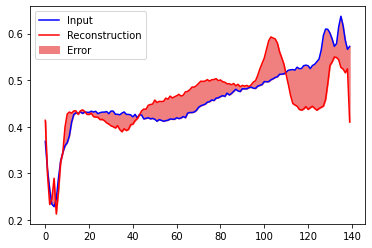

In [ ]:
## Create a similar plot, this time for an anomalous test
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

#Check Anomalous data and Decoded data 

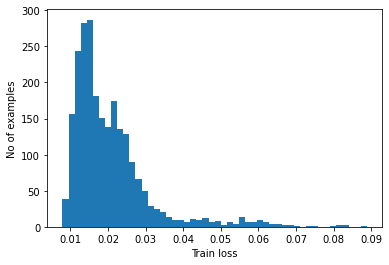

In [ ]:
# Detect anomalies by calculating whether the reconstruction loss is greater than 
# a fixed threshold. In this tutorial, you will calculate the mean average error
# for normal examples from the training set, then classify future examples as 
# anomalous if the reconstruction error is higher than one standard deviation from the training set.
# Plot the reconstruction error on normal ECGs from the training set

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

### Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.030993763


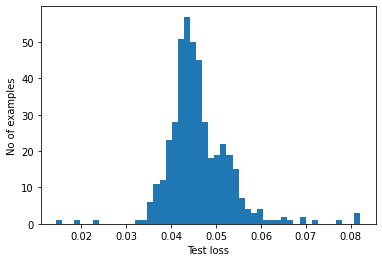

In [ ]:
##If you examine the reconstruction error for the anomalous examples in the test set,
# you'll notice most have greater reconstruction error than the threshold. 

#By varing the threshold, you can adjust the precision and recall of your classifier.
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
##Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

preds = predict(autoencoder, test_data, threshold)

In [ ]:
preds[:10]

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([False, False,  True,  True, False, False,  True,  True, False,
        True])>

In [ ]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9941291585127201
Recall = 0.9071428571428571
